In [ ]:
%pip install catboost optuna

Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install seaborn scikit-learn pandas xgboost lightgbm

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import copy
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from catboost import cv, Pool
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
import optuna
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

##Работа с данными

In [ ]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [ ]:
df_train.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,55.0,150.0,50.0,73.0,0.8,1.0,1.0,1.0,122.0,...,62.0,113.0,12.0,1.0,0.6,22.0,21.0,12.0,0.0,0.0
1,1,50.0,160.0,60.0,79.6,1.0,0.8,1.0,1.0,124.0,...,74.0,112.0,14.1,1.0,0.9,19.0,14.0,17.0,0.0,0.0
2,2,55.0,145.0,50.0,73.0,1.2,1.2,1.0,1.0,110.0,...,66.0,123.0,13.3,1.0,0.6,15.0,12.0,13.0,0.0,0.0
3,3,40.0,175.0,80.0,83.2,0.9,1.0,1.0,1.0,99.0,...,38.0,114.0,16.1,1.0,1.0,22.0,13.0,20.0,0.0,1.0
4,4,30.0,170.0,70.0,79.5,1.2,1.2,1.0,1.0,119.0,...,49.0,148.0,15.5,1.0,1.2,18.0,19.0,25.0,0.0,1.0


In [ ]:
df_test.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
0,15000,40.0,155.0,45.0,64.0,0.9,0.9,1.0,1.0,109.0,...,50.0,79.0,108.0,13.3,1.0,0.9,16.0,11.0,17.0,0.0
1,15001,45.0,175.0,90.0,101.0,1.0,1.2,1.0,1.0,130.0,...,147.0,38.0,99.0,16.2,1.0,0.9,23.0,21.0,28.0,1.0
2,15002,40.0,165.0,60.0,78.0,1.5,1.5,1.0,1.0,107.0,...,60.0,67.0,136.0,14.9,1.0,0.9,30.0,36.0,16.0,0.0
3,15003,35.0,170.0,60.0,84.5,1.0,1.0,1.0,1.0,124.0,...,127.0,63.0,128.0,15.4,1.0,0.8,21.0,17.0,26.0,1.0
4,15004,40.0,155.0,45.0,68.5,1.0,1.0,1.0,1.0,109.0,...,47.0,61.0,133.0,11.5,1.0,0.7,22.0,12.0,17.0,0.0


In [ ]:
print(df_train['smoking'].describe())

count    15000.000000
mean         0.366600
std          0.481892
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: smoking, dtype: float64


In [ ]:
print("Кол-во null значений в df_train:", df_train.isnull().sum().sum())
print("Кол-во null значений в df_test:", df_test.isnull().sum().sum())

Кол-во null значений в df_train: 0
Кол-во null значений в df_test: 0


In [ ]:
print("Кол-во NA значений в df_train:", df_train.isna().sum().sum())
print("Кол-во NA значений в df_test:", df_test.isna().sum().sum())

Кол-во NA значений в df_train: 0
Кол-во NA значений в df_test: 0


In [ ]:
print("Кол-во дубликатов в df_train:", df_train.duplicated().sum().sum())
print("Кол-во дубликатов в df_test:", df_test.duplicated().sum().sum())

Кол-во дубликатов в df_train: 0
Кол-во дубликатов в df_test: 0


In [ ]:
print(df_train.describe())

                 id           age    height(cm)    weight(kg)     waist(cm)  \
count  15000.000000  15000.000000  15000.000000  15000.000000  15000.000000   
mean    7499.500000     42.606000    164.672667     64.282000     80.323180   
std     4330.271354     10.415341      8.558684     10.973871      7.932701   
min        0.000000     20.000000    140.000000     35.000000      0.900000   
25%     3749.750000     40.000000    160.000000     55.000000     75.000000   
50%     7499.500000     40.000000    165.000000     65.000000     80.000000   
75%    11249.250000     50.000000    170.000000     70.000000     86.000000   
max    14999.000000     80.000000    190.000000    120.000000    121.000000   

       eyesight(left)  eyesight(right)  hearing(left)  hearing(right)  \
count    15000.000000     15000.000000   15000.000000    15000.000000   
mean         1.032727         1.025927       1.005533        1.004933   
std          0.312845         0.313488       0.074183        0.070067

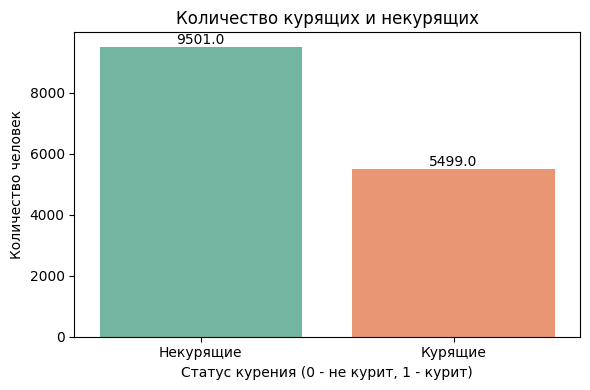

In [ ]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(data=df_train, x='smoking', hue='smoking', palette='Set2', legend=False)

ax.set_title('Количество курящих и некурящих')
ax.set_xlabel('Статус курения (0 - не курит, 1 - курит)')
ax.set_ylabel('Количество человек')
plt.xticks([0, 1], ['Некурящие', 'Курящие'])

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

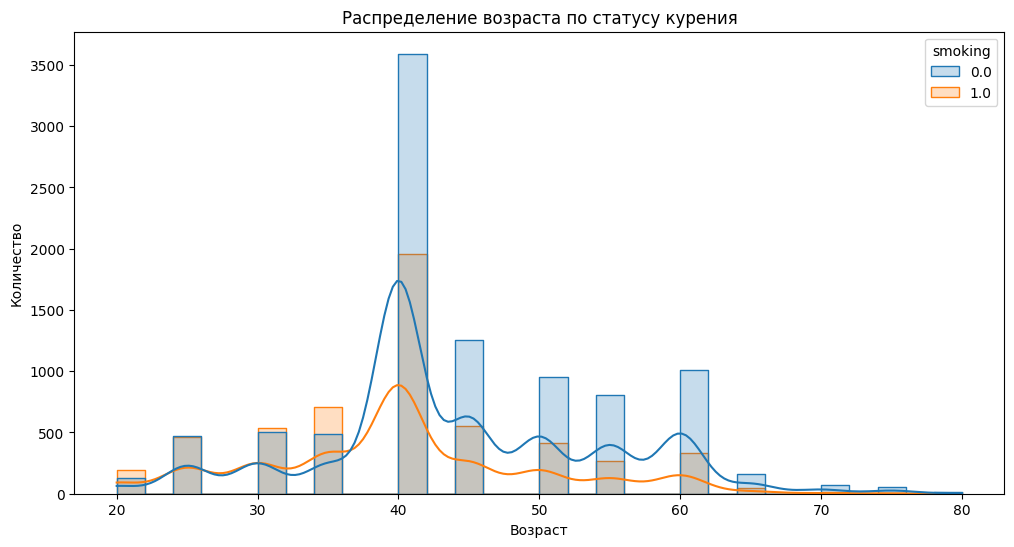

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df_train, x='age', hue='smoking', bins=30, kde=True, element='step')
plt.title('Распределение возраста по статусу курения')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.show()

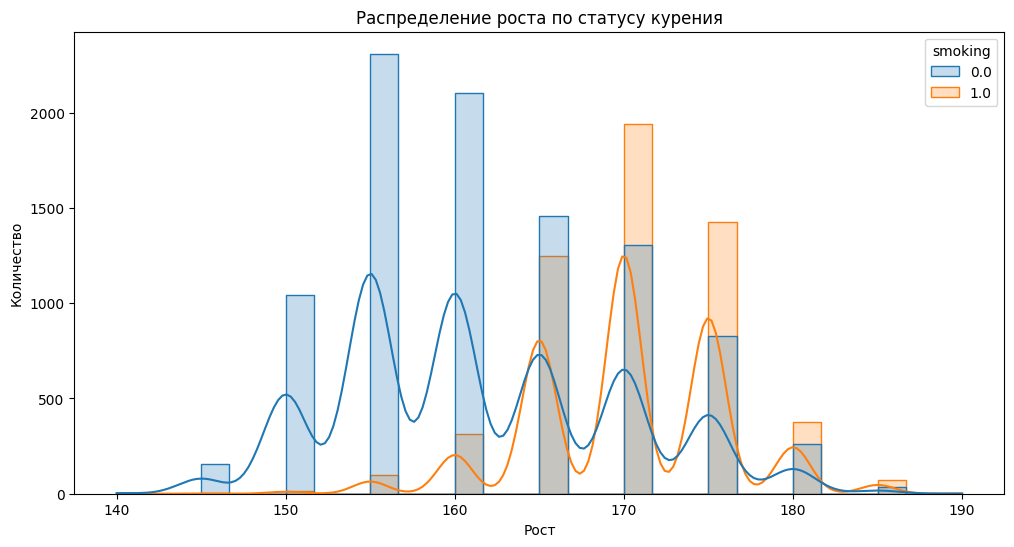

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df_train, x='height(cm)', hue='smoking', bins=30, kde=True, element='step')
plt.title('Распределение роста по статусу курения')
plt.xlabel('Рост')
plt.ylabel('Количество')
plt.show()

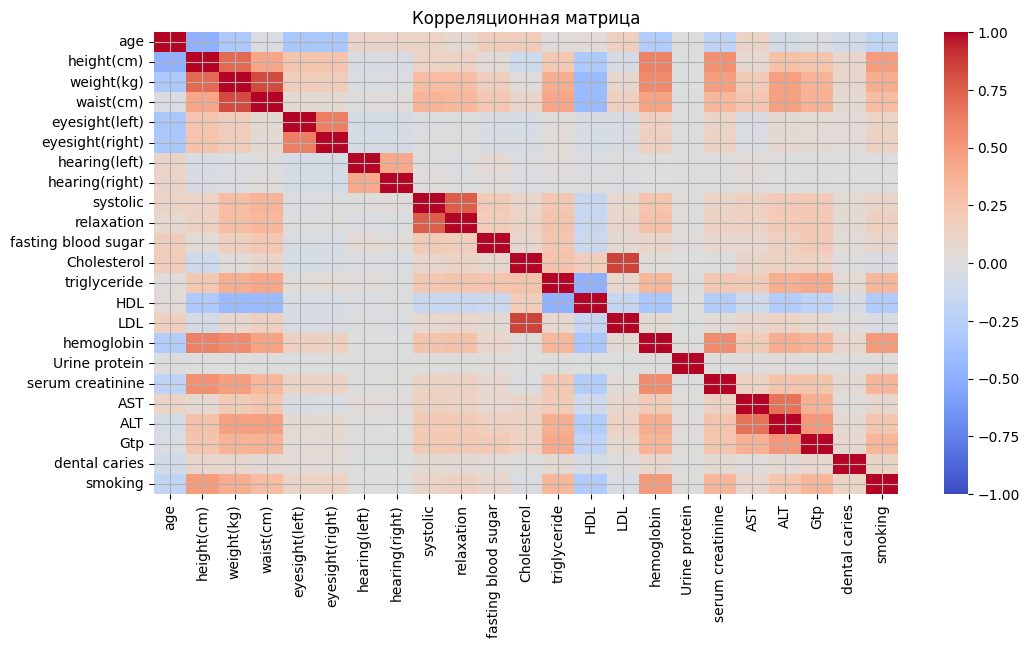

In [ ]:
def show_corr_matrix(data, min_corr=0.0, max_corr=1.0, annot=False, dropTarget=True, fmt='.2g', figsize=(12, 6), grid=False, name="Корреляционная матрица"):
    if dropTarget:
        data = data.drop(columns='id', errors='ignore')
    corr_matrix = data.corr()

    mask = (corr_matrix.abs() >= min_corr) & (corr_matrix.abs() <= max_corr)
    corr_filtered = corr_matrix.where(mask)

    plt.figure(figsize=figsize)
    sns.heatmap(corr_filtered, cmap='coolwarm', vmin=-1, vmax=1, annot=annot, fmt=fmt)
    plt.title(name)
    plt.grid(grid)
    plt.show()

show_corr_matrix(df_train, grid=True)

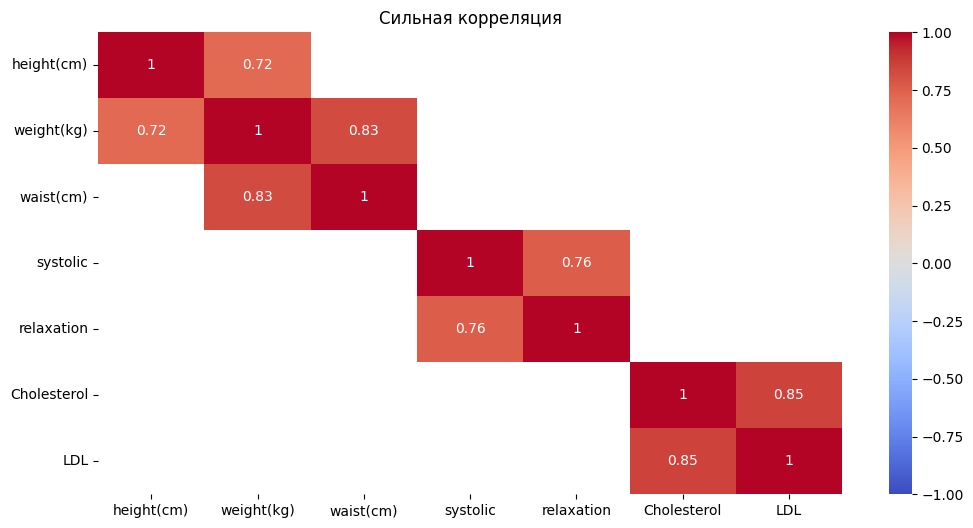

In [ ]:
corr_matrix = df_train.drop(columns=['id']).corr()

weak_corr_columns = corr_matrix.columns[corr_matrix.abs().apply(lambda x: x[x < 1].max(), axis=0) < 0.7]

show_corr_matrix(
    df_train.drop(columns=weak_corr_columns),
    min_corr=0.7,
    annot=True,
    name='Сильная корреляция'
)

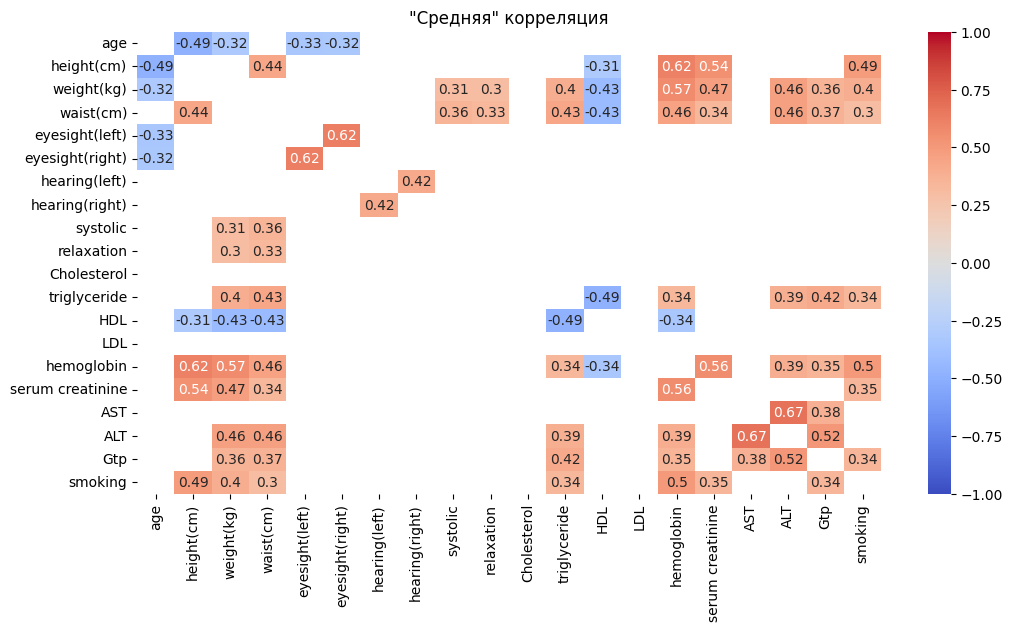

In [ ]:
corr_matrix = df_train.drop(columns=['id']).corr()

weak_corr_columns = corr_matrix.columns[corr_matrix.abs().apply(lambda x: x[x < 1].max(), axis=0) < 0.3]

show_corr_matrix(
    df_train.drop(columns=weak_corr_columns),
    min_corr=0.3,
    max_corr=0.7,
    annot=True,
    name='"Средняя" корреляция'
)

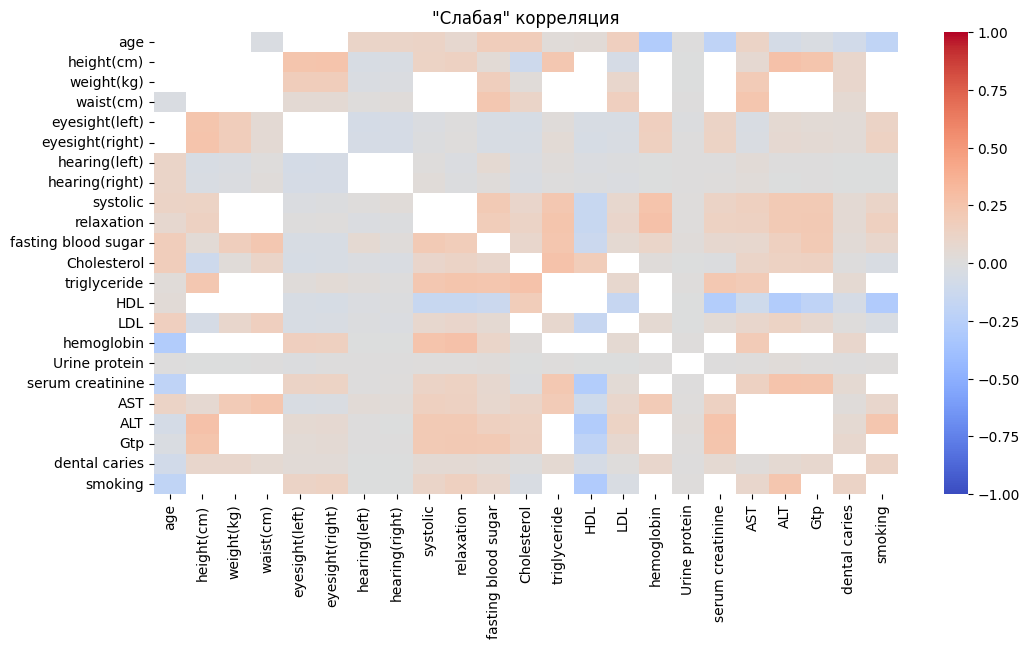

In [ ]:
corr_matrix = df_train.drop(columns=['id']).corr()

weak_corr_columns = corr_matrix.columns[corr_matrix.abs().apply(lambda x: x[x < 1].max(), axis=0) < 0]

show_corr_matrix(
    df_train.drop(columns=weak_corr_columns),
    min_corr=0,
    max_corr=0.3,
    name='"Слабая" корреляция'
)

##Бэггинг

In [ ]:
class MyBaggingClassifier:
    def __init__(self, base_estimator=DecisionTreeClassifier(), n_estimators=10, random_state=None):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.estimators = []

    def fit(self, X, y):
        for i in range(self.n_estimators):
          rng = np.random.RandomState(self.random_state + i if self.random_state is not None else None)
          idx = rng.choice(len(X), size=len(X), replace=True)

          X_sample = X[idx] if isinstance(X, np.ndarray) else X.iloc[idx]
          y_sample = y[idx] if isinstance(y, np.ndarray) else y.iloc[idx]

          estimator = copy.deepcopy(self.base_estimator)
          estimator.fit(X_sample, y_sample)
          self.estimators.append(estimator)

    def predict_proba(self, X):
        probas = np.array([estimator.predict_proba(X) for estimator in self.estimators])
        return np.mean(probas, axis=0)

    def predict(self, X):
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)

In [ ]:
X = df_train.drop(columns=['id','smoking'])
y = df_train['smoking']

X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = df_test.drop(columns='id')

In [ ]:
base_estimator = DecisionTreeClassifier(max_depth=5)
my_bagging = MyBaggingClassifier(base_estimator=base_estimator, random_state=42)
my_bagging.fit(X_train, y_train)
my_predict = my_bagging.predict_proba(X_validate)[:, 1]

sk_bagging = BaggingClassifier(base_estimator, random_state=42)
sk_bagging.fit(X_train, y_train)
sk_predict = sk_bagging.predict_proba(X_validate)[:, 1]

print(f"\nMy BC: {roc_auc_score(y_validate, my_predict):.4f}")
print(f"Sklearn BC: {roc_auc_score(y_validate, sk_predict):.4f}")


My BC: 0.8686
Sklearn BC: 0.8692


##Градиентный бустинг

In [ ]:
class MyGradientBoosting:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, random_state=None):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.random_state = random_state
        self.estimators = []

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def fit(self, X, y):
        X, y = np.array(X), np.array(y)
        np.random.seed(self.random_state)

        self.classes_ = np.unique(y)
        if len(self.classes_) != 2:
            raise ValueError("MyGradientBoosting поддерживает только бинарную классификацию")

        eps = 1e-15
        pos_rate = np.clip(np.mean(y), eps, 1 - eps)
        self.initial_pred = np.log(pos_rate / (1 - pos_rate))

        pred = np.full(X.shape[0], self.initial_pred, dtype=np.float64)

        for i in range(self.n_estimators):
            residuals = y - self._sigmoid(pred)

            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=self.random_state)
            tree.fit(X, residuals)
            self.estimators.append(tree)

            pred += self.learning_rate * tree.predict(X)

    def predict_proba(self, X):
        X = np.array(X)
        pred = np.full(X.shape[0], self.initial_pred)
        for estimator in self.estimators:
            pred += self.learning_rate * estimator.predict(X)
        prob = self._sigmoid(pred)
        return np.vstack([1 - prob, prob]).T

    def predict(self, X):
        pred_proba = self.predict_proba(X)
        return np.argmax(pred_proba, axis=1)

In [ ]:
X = df_train.drop(columns=['id','smoking'])
y = df_train['smoking']

X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = df_test.drop(columns='id')

In [ ]:
my_gb = MyGradientBoosting(n_estimators=100, max_depth=5, random_state=42)
my_gb.fit(X_train, y_train)
my_predict = my_gb.predict_proba(X_validate)[:, 1]

sk_gb = GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42)
sk_gb.fit(X_train, y_train)
sk_predict = sk_gb.predict_proba(X_validate)[:, 1]

print(f"\nMy GB: {roc_auc_score(y_validate, my_predict):.4f}")
print(f"Sklearn GB: {roc_auc_score(y_validate, sk_predict):.4f}")


My GB: 0.8814
Sklearn GB: 0.8903


##Сравнение библиотек

In [ ]:
def compare(X_train, y_train, estimators, cv_folds=5):
    results = []

    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

    for name, estimator in estimators.items():
        auc_scores = cross_val_score(estimator, X_train, y_train, cv=cv, scoring='roc_auc')
        mean_auc = np.mean(auc_scores)
        results.append((name, mean_auc))
        print(f"{name}: ROC-AUC = {mean_auc:.4f}")

    return max(results, key=lambda x: x[1])

estimators = {
        "Sklearn GB": GradientBoostingClassifier(random_state=42),
        "XGBoost": XGBClassifier(random_state=42),
        "LightGBM": LGBMClassifier(random_state=42, verbose=-1),
        "CatBoost": CatBoostClassifier(random_state=42, verbose=0)
    }

best_model, best_auc = compare(X_train, y_train, estimators)
print(f"Лучшая модель: {best_model} имеет ROC-AUC: {best_auc:.4f}")

Sklearn GB: ROC-AUC = 0.8807
XGBoost: ROC-AUC = 0.8767
LightGBM: ROC-AUC = 0.8809
CatBoost: ROC-AUC = 0.8853
Лучшая модель: CatBoost имеет ROC-AUC: 0.8853


Лучшим себя показал CatBoost.

##Оптимизация гиперпараметров

In [ ]:
X = df_train.drop(columns=['id','smoking'])
y = df_train['smoking']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 400, 1500),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-1, 10.0, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_strength': trial.suggest_float('random_strength', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'loss_function': 'Logloss',
        "eval_metric":   "AUC",
        'random_state': 42,
    }
    model = CatBoostClassifier(**params, verbose=0)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')

    return np.mean(auc_scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Лучшие гиперпараметры:", study.best_params)
print("ROC-AUC:", study.best_value)

[I 2025-05-25 14:19:14,684] A new study created in memory with name: no-name-0d67b8d8-72dc-4978-a272-2a13d762f736
[I 2025-05-25 14:19:56,314] Trial 0 finished with value: 0.8796328201350304 and parameters: {'iterations': 602, 'max_depth': 12, 'learning_rate': 0.05281223461093983, 'reg_lambda': 2.050950441699378, 'bagging_temperature': 0.5600809045992559, 'random_strength': 0.9837091107808551, 'border_count': 118}. Best is trial 0 with value: 0.8796328201350304.
[I 2025-05-25 14:20:01,360] Trial 1 finished with value: 0.8877140540961905 and parameters: {'iterations': 485, 'max_depth': 6, 'learning_rate': 0.030731701822503257, 'reg_lambda': 2.043360715546011, 'bagging_temperature': 0.8502225785962738, 'random_strength': 0.7187656338139757, 'border_count': 112}. Best is trial 1 with value: 0.8877140540961905.
[I 2025-05-25 14:21:23,097] Trial 2 finished with value: 0.8786707944990635 and parameters: {'iterations': 794, 'max_depth': 12, 'learning_rate': 0.08185830890442494, 'reg_lambda': 0

Лучшие гиперпараметры: {'iterations': 512, 'max_depth': 7, 'learning_rate': 0.024031689221968928, 'reg_lambda': 2.562410088740739, 'bagging_temperature': 0.42695291106992206, 'random_strength': 0.6904885645314116, 'border_count': 199}
ROC-AUC: 0.8884077735865775


##Финальное обучение

In [ ]:
final_model = CatBoostClassifier(
    **study.best_params,
    random_state=42,
    verbose=0
)
final_model.fit(X_train, y_train)

In [ ]:
X_submit = df_test.drop(columns=['id'])
submit_preds = final_model.predict_proba(X_submit.values)[:, 1]

submission = pd.DataFrame({
    'id': df_test['id'],
    'smoking': submit_preds
})

submission.to_csv('submission.csv', index=False)

##Реализация метрик

In [ ]:
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def precision(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    return tp / (tp + fp) if (tp + fp) > 0 else 0

def recall(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp / (tp + fn) if (tp + fn) > 0 else 0

def my_f1_score(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0

def my_auc_roc_score(y_true, y_scores):
    desc_order = np.argsort(-y_scores)
    y_true = np.array(y_true)[desc_order]
    y_scores = np.array(y_scores)[desc_order]

    tpr_list = []
    fpr_list = []

    P = np.sum(y_true == 1)
    N = np.sum(y_true == 0)
    tp = 0
    fp = 0

    for i in range(len(y_true)):
        if y_true[i] == 1:
            tp += 1
        else:
            fp += 1
        tpr_list.append(tp / P if P else 0)
        fpr_list.append(fp / N if N else 0)

    auc = np.trapezoid(tpr_list, fpr_list)
    return auc

def my_auc_pr_score(y_true, y_scores):
    desc_order = np.argsort(-y_scores)
    y_true = np.array(y_true)[desc_order]

    precisions = []
    recalls = []

    tp = 0
    fp = 0
    fn = np.sum(y_true == 1)

    for i in range(len(y_true)):
        if y_true[i] == 1:
            tp += 1
            fn -= 1
        else:
            fp += 1

        prec = tp / (tp + fp) if (tp + fp) > 0 else 0
        rec = tp / (tp + fn) if (tp + fn) > 0 else 0
        precisions.append(prec)
        recalls.append(rec)

    auc_pr = np.trapezoid(precisions, recalls)
    return auc_pr

y_pred = final_model.predict(X_validate)
y_scores = final_model.predict_proba(X_validate)[:, 1]

results = {
    "Метрика": ["Accuracy", "Precision", "Recall", "F1 Score", "AUC-ROC", "AUC-PR"],
    "Моя реализация": [
        accuracy(y_validate, y_pred),
        precision(y_validate, y_pred),
        recall(y_validate, y_pred),
        my_f1_score(y_validate, y_pred),
        my_auc_roc_score(y_validate, y_scores),
        my_auc_pr_score(y_validate, y_scores)
    ],
    "Sklearn": [
        accuracy_score(y_validate, y_pred),
        precision_score(y_validate, y_pred),
        recall_score(y_validate, y_pred),
        f1_score(y_validate, y_pred),
        roc_auc_score(y_validate, y_scores),
        average_precision_score(y_validate, y_scores)
    ]
}

df = pd.DataFrame(results)
df["Разница"] = abs(df["Моя реализация"] - df["Sklearn"])

print("\nСравнение метрик:")
print(df.round(4))


Сравнение метрик:
     Метрика  Моя реализация  Sklearn  Разница
0   Accuracy          0.8630   0.8630   0.0000
1  Precision          0.8015   0.8015   0.0000
2     Recall          0.8500   0.8500   0.0000
3   F1 Score          0.8250   0.8250   0.0000
4    AUC-ROC          0.9359   0.9359   0.0000
5     AUC-PR          0.8935   0.8944   0.0009
